In [32]:
#Basic imports
import os
import numpy as np
from shutil import copyfile
from sys import platform

#Dataset imports
import csv

#Imports for image load/unload/process
from cv2 import imread, imwrite, cvtColor, COLOR_BGR2RGB
from skimage import transform

#Plotting libs
from matplotlib import pyplot as plt

#Graph keras model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#Keras imports
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Activation
from keras.utils import to_categorical

In [24]:
### Constants ###

#Dataset constants for Windows
if platform.startswith("win"):
    RAW_TRAIN_SET_LOC = "..\\Humpback Whale\\dataset\\train"
    TRAIN_SET_LOC = "..\\Humpback Whale\\dataset\\train_resized"
    PROCESSED_SET_LOC = "..\\Humpback Whale\\dataset\\processed"
    RAW_TEST_SET_LOC = "..\\Humpback Whale\\dataset\\test"
    TEST_SET_LOC = "..\\Humpback Whale\\dataset\\test_resized"
    LABEL_FILE_LOC = "..\\Humpback Whale\\dataset\\train.csv"
else:
    RAW_TRAIN_SET_LOC = "dataset/train"
    TRAIN_SET_LOC = "dataset/train_resized"
    PROCESSED_SET_LOC = "dataset/processed"
    RAW_TEST_SET_LOC = "dataset/test"
    TEST_SET_LOC = "dataset/test_resized"
    LABEL_FILE_LOC = "dataset/train.csv"

#Dataset markers
TRAIN_SET_SIZE = 20
TEST_SET_SIZE = 10
PREPROCESS_BATCH_START = 0
PREPROCESS_BATCH_SIZE = 500

#Image parameter constants
IMG_SIZE = (400, 700, 3)
IMG_WIDTH = 700
IMG_HEIGHT = 400
IMG_EXTN = "jpg"

#Sampling
SAMPLE_IMG_ID = 5

#Containers
LABEL_DICT = {} 
X_TRAIN = []
Y_TRAIN = []
X_TEST = []
Y_TEST = []
CLASS_NAMES = []
CLASSES = []
NUM_CLASSES = 0

In [28]:
#Utility methods

def locate_img(path, img_name):
    return os.path.join(path, img_name)

def load_dataset(dataset_path, files):
    images = []
    loaded_images = 0
    for file in files:
        images.append(imread(locate_img(dataset_path, file)))
        loaded_images = loaded_images + 1
        
        if loaded_images % 1000 == 0:
            print("Loaded {num} images".format(num = loaded_images))
    
    return np.asarray(images)

def resize_images(images):
    #impad() changes the image data from [0..255] range to [0..1]
    resized_images = [impad(image, IMG_SIZE) for image in images]
    print("Resized {num} images to {size}".format(num = len(resized_images), size = IMG_SIZE))
    
    return resized_images
    
def save_dataset(target_path, files, image_data):
    for idx, file in enumerate(files):
        data = image_data[idx]
        file_path = locate_img(target_path, file)
        imwrite(file_path, (data*255).astype('uint8'))
        
def save_processed(source_path, files, target_path):
    for idx, file in enumerate(files):
        src_file_path = locate_img(source_path, file)
        dst_file_path = locate_img(target_path, file)
        copyfile(src_file_path, dst_file_path)

def preprocess_raw_dataset(source_dataset_path, files, target_dataset_path, batch_size = PREPROCESS_BATCH_SIZE):
    for batch_id, batch_files in enumerate(batch(files, batch_size)):
        print("Processing batch_id: {batch_id}".format(batch_id = batch_id))
        
        batch_images = load_dataset(source_dataset_path, batch_files)
        resized_batch = resize_images(batch_images)
        save_dataset(target_dataset_path, batch_files, resized_batch)
        save_processed(source_dataset_path, batch_files, PROCESSED_SET_LOC)
        
def batch(iterable, batch_size = 1):
    count = len(iterable)
    for batch_idx in range(0, count, batch_size):
        yield iterable[batch_idx:min(batch_idx + batch_size, count)]

def impad(image, target_size):
    return transform.resize(image, target_size, anti_aliasing = True)

def load_model_data(source_path, files, batch_size, class_name_map, label_dict, num_classes):
    #Image batch placeholder
    x = None
    
    #Labels placeholder
    y = None

    while True:
        for batch_files in batch(files, batch_size):
            #Load images
            x = load_dataset(source_path, batch_files)

            #Normalize
            x = np.array(x/255)

            y = [class_name_map[label_dict[image]] for image in batch_files]
            y = to_categorical(y, num_classes = num_classes)

            yield [x], y
    

In [30]:
### Create label and class mapping for training set. ###

#Load labels
LABEL_DICT = {}

with open(LABEL_FILE_LOC, 'r') as handle:
    label_reader = csv.reader(handle)
    next(label_reader, None)
    
    loaded_items = 0
    for row in label_reader:
        LABEL_DICT[row[0]] = row[1]
    
#Classes
CLASS_NAMES = list(set(LABEL_DICT.values()))
CLASS_NAME_MAP = {}

class_idx = 0
for class_name in CLASS_NAMES:
    CLASS_NAME_MAP[class_name] = class_idx
    class_idx += 1

NUM_CLASSES = len(CLASS_NAMES)

print("Number of classses: {count}".format(count = NUM_CLASSES))

Number of classses: 5005


In [ ]:
### Preprocess train dataset ###
train_raw_files = train_files = list(LABEL_DICT.keys())[:500]

preprocess_raw_dataset(RAW_TRAIN_SET_LOC, train_raw_files, TRAIN_SET_LOC, 100)

"""
train_raw_files = ["0000e88ab.jpg"]
image = imread(locate_img(RAW_TRAIN_SET_LOC, "0000e88ab.jpg"))
resized = load_dataset(RAW_TRAIN_SET_LOC, train_raw_files)
print(resized[0])
"""

Processing batch_id: 0


C:\Users\nares\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Resized 100 images to (400, 700, 3)
Processing batch_id: 1
Resized 100 images to (400, 700, 3)
Processing batch_id: 2
Resized 100 images to (400, 700, 3)
Processing batch_id: 3
Resized 100 images to (400, 700, 3)
Processing batch_id: 4


[0. 0. 0. ... 0. 0. 0.]


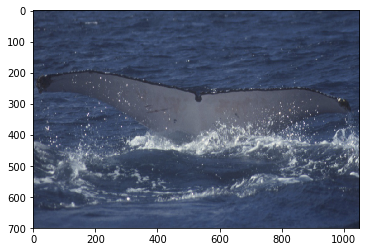

In [16]:
files = list(LABEL_DICT.keys())[:10]

x = load_dataset(TRAIN_SET_LOC, files)

y = [CLASS_NAME_MAP[LABEL_DICT[image]] for image in files]
y = to_categorical(y, num_classes = NUM_CLASSES)

#Print sample
plt.figure()

plt.imshow(cvtColor((x[4]).astype('uint8'), COLOR_BGR2RGB)) #SAMPLE_IMG_ID

print(y[4])

In [ ]:
### Create the model ###
model = Sequential()

input_shape = (700, 1050, 3)

model.add(MaxPool2D((5, 5), (2, 2), 'valid', input_shape=input_shape))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((5, 5), (2, 2), 'valid'))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D((5, 5), (2, 2), 'valid'))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D((5, 5), (2, 2), 'valid'))

model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(MaxPool2D((5, 5), (2, 2), 'valid'))

model.add(Conv2D(4, kernel_size=3, activation='relu'))
model.add(MaxPool2D((5, 5), (2, 2), 'valid'))

model.add(Flatten())
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Print model summary
print(model.summary())

#Train the model
files = list(LABEL_DICT.keys())[:5096]
batch_size = 16
model.fit_generator(
    load_model_data(TRAIN_SET_LOC, files, 16, CLASS_NAME_MAP, LABEL_DICT, NUM_CLASSES),
    epochs = 20, 
    steps_per_epoch = len(files)/batch_size + 1, 
    use_multiprocessing = True)
"""
for files in batch(list(LABEL_DICT.keys()), 256):
    x, y = load_image_set(TRAIN_SET_LOC, files, CLASS_NAME_MAP, LABEL_DICT, NUM_CLASSES)
    model.fit(x, y, batch_size = 16, validation_split = 0.2, epochs=3)
"""

#VG(model_to_dot(model).create(prog='dot', format='s

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 348, 523, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 348, 523, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 172, 260, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 258, 64)      73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 83, 127, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 81, 125, 32)       18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 61, 32)        0         
__________

In [ ]:
#Scratch
#img = imread(locate_train_img("0000e88ab.jpg"))

In [ ]:
print(X_TRAIN.shape)